In [3]:
# Gerekli Kütüphanelerin Yüklenmesi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from IPython.display import display
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

# Görselleştirme ayarı
sns.set_style("whitegrid")

Veri Seti Boyutu: (13028, 69)


/tmp/ipython-input-484374627.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis')


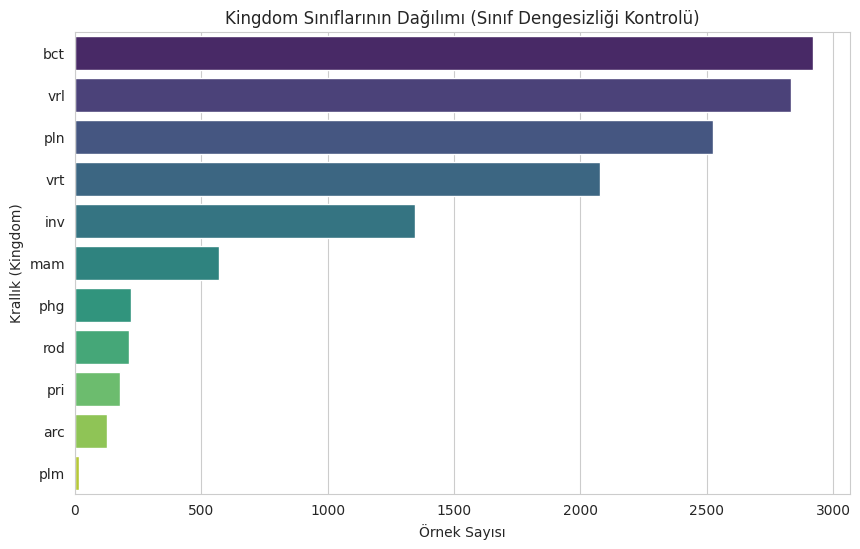

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,vrl,0,100217,1995,Epizootic haematopoietic necrosis virus,0.01654,0.01203,0.00050,0.00351,0.01203,...,0.00451,0.01303,0.03559,0.01003,0.04612,0.01203,0.04361,0.00251,0.00050,0.00000
1,vrl,0,100220,1474,Bohle iridovirus,0.02714,0.01357,0.00068,0.00678,0.00407,...,0.00136,0.01696,0.03596,0.01221,0.04545,0.01560,0.04410,0.00271,0.00068,0.00000
2,vrl,0,100755,4862,Sweet potato leaf curl virus,0.01974,0.0218,0.01357,0.01543,0.00782,...,0.00596,0.01974,0.02489,0.03126,0.02036,0.02242,0.02468,0.00391,0.00000,0.00144
3,vrl,0,100880,1915,Northern cereal mosaic virus,0.01775,0.02245,0.01619,0.00992,0.01567,...,0.00366,0.01410,0.01671,0.03760,0.01932,0.03029,0.03446,0.00261,0.00157,0.00000
4,vrl,0,100887,22831,Soil-borne cereal mosaic virus,0.02816,0.01371,0.00767,0.03679,0.01380,...,0.00604,0.01494,0.01734,0.04148,0.02483,0.03359,0.03679,0.00000,0.00044,0.00131


In [4]:
# Veri setinin yüklenmesi
df = pd.read_csv("codon_usage.csv", low_memory=False)

print("Veri Seti Boyutu:", df.shape)

# Kingdom sınıf dağılımının görselleştirilmesi
plt.figure(figsize=(10, 6))
sns.countplot(y='Kingdom', data=df, order=df['Kingdom'].value_counts().index, palette='viridis')
plt.title('Kingdom Sınıflarının Dağılımı (Sınıf Dengesizliği Kontrolü)')
plt.xlabel('Örnek Sayısı')
plt.ylabel('Krallık (Kingdom)')
plt.show()

# İlk 5 satırı göster:
display(df.head())

In [5]:
# 3. Ön Tanımlamalar
# Kodon sütunları (5. sütundan itibaren)
codon_cols = df.columns[5:]
# Diğer sayısal sütunlar (Ncodons, DNAtype)
other_numeric_cols = ['Ncodons', 'DNAtype']
# Tüm sayısal özellikler
numeric_features = list(codon_cols) + other_numeric_cols

print("--- Temizlik Başlangıcı ---")
for col in numeric_features:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(
            df[col].astype(str).str.replace(",", ".", regex=False),
            errors="coerce"
        )

# İhtiyaç olmayan tanımlayıcı sütunları çıkar
df_cleaned = df.drop(columns=['SpeciesID', 'SpeciesName']).copy()

--- Temizlik Başlangıcı ---


In [6]:
# 4. Veri Ayırma (Split) - Imputation'dan Önce
X = df_cleaned.drop(columns=['Kingdom'])
y = df_cleaned['Kingdom']

# %80 Eğitim / %20 Test, Krallığa göre katmanlı
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Eğitim ve test setlerini tek DataFrame'lerde birleştirme
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print("\n--- Veri Ayırma Sonuçları ---")
print(f"X_train Boyutu: {X_train.shape}")
print(f"X_test Boyutu: {X_test.shape}")


--- Veri Ayırma Sonuçları ---
X_train Boyutu: (10422, 66)
X_test Boyutu: (2606, 66)


In [7]:
# 5. Eksik Değer Doldurma (Imputation)

# Train setindeki her bir sayısal sütunun ortalamasını hesapla
# Bu ortalamayı, hem Train hem de Test setini doldurmak için kullanma işlemi
train_means = train_df[numeric_features].mean()

# Train ve Test setlerini, Train setinin ortalamaları ile doldur
train_df[numeric_features] = train_df[numeric_features].fillna(train_means)
test_df[numeric_features] = test_df[numeric_features].fillna(train_means)

print("Eksik Değer Doldurma Tamamlandı. Test seti, Train ortalaması ile dolduruldu.")

# --- Encoding (Hedef Değişken Kodlama) ---
le = LabelEncoder()
train_df['Kingdom_Encoded'] = le.fit_transform(train_df['Kingdom'])
test_df['Kingdom_Encoded'] = le.transform(test_df['Kingdom'])

print("Krallık Kodlaması:", dict(zip(le.classes_, le.transform(le.classes_))))

# --- Scaling (Ölçeklendirme) ---
scaler = StandardScaler()

# Scaler'ı sadece eğitim verisine fit et
scaler.fit(train_df[numeric_features])

# Train ve Test setlerini ölçekle
train_df[numeric_features] = scaler.transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

print("Ölçeklendirme Tamamlandı. Ncodons ve Kodonlar Standardize Edildi.")

Eksik Değer Doldurma Tamamlandı. Test seti, Train ortalaması ile dolduruldu.
Krallık Kodlaması: {'arc': np.int64(0), 'bct': np.int64(1), 'inv': np.int64(2), 'mam': np.int64(3), 'phg': np.int64(4), 'plm': np.int64(5), 'pln': np.int64(6), 'pri': np.int64(7), 'rod': np.int64(8), 'vrl': np.int64(9), 'vrt': np.int64(10)}
Ölçeklendirme Tamamlandı. Ncodons ve Kodonlar Standardize Edildi.


In [8]:
# 6. Nihai X ve y setlerini oluştur
X_train_final = train_df.drop(columns=['Kingdom', 'Kingdom_Encoded'])
y_train_final = train_df['Kingdom_Encoded']
X_test_final = test_df.drop(columns=['Kingdom', 'Kingdom_Encoded'])
y_test_final = test_df['Kingdom_Encoded']

# Sonuçları CSV olarak kaydet
X_train_final.to_csv('X_train_final_Adim.csv', index=False)
X_test_final.to_csv('X_test_final_Adim.csv', index=False)
pd.DataFrame({'Kingdom_Encoded': y_train_final.values, 'Kingdom_Original': train_df['Kingdom'].values}).to_csv('y_train_encoded_final_Adim.csv', index=False)
pd.DataFrame({'Kingdom_Encoded': y_test_final.values, 'Kingdom_Original': test_df['Kingdom'].values}).to_csv('y_test_encoded_final_Adim.csv', index=False)

print("Tüm hazırlık adımları tamamlandı. Veriler dosyalara kaydedildi.")

Tüm hazırlık adımları tamamlandı. Veriler dosyalara kaydedildi.


In [9]:

# EXTRA TREES
# ==============================================================================

# Extra Trees için Veri Mühendisliği(FE) Kısmı

# Extra Trees için ayrı bir DataFrame kopyası oluştur
X_train_et = X_train_final.copy()
X_test_et = X_test_final.copy()

print("--- 1. Extra Trees İçin Öznitelik Mühendisliği (FE) ---")

# --- Kodon listeleri veri setine göre düzeltildi (RNA Tabanlı) ---
# Yüksek GC içeriği olan kodonlar (G, C içerenler)
gc_rich_codons = [
    'GGU', 'GGC', 'GGA', 'GGG', 'GCU', 'GCC', 'GCA', 'GCG',
    'CCU', 'CCC', 'CCA', 'CCG', 'CGU', 'CGC', 'CGA', 'CGG',
    'UGU', 'UGC', 'GAU', 'GAC', 'GAA', 'GAG', 'CAU', 'CAC',
    'CAA', 'CAG', 'AAG', 'AGG', 'UGG'
]

# Yüksek AU içeriği olan kodonlar (A, U içerenler)
at_rich_codons = [
    'UUU', 'UUC', 'UUA', 'UUG', 'AUU', 'AUC', 'AUA', 'AAA',
    'AAU', 'AAC', 'UAU', 'UAC', 'UAA', 'UAG', 'UGA'
]

# Ortak kodda çıkarılmamış olanları filtrelemek için mevcut sütunları kullandık
existing_codons = X_train_et.columns[4:] #kodon sütunlarının temsili

gc_rich_codons = [c for c in existing_codons if c in gc_rich_codons]
at_rich_codons = [c for c in existing_codons if c in at_rich_codons]


# Yeni Özellik 1: GC-Yoğun Kodon Toplamı (GC_SCORE)
X_train_et['GC_SCORE'] = X_train_et[gc_rich_codons].sum(axis=1)
X_test_et['GC_SCORE'] = X_test_et[gc_rich_codons].sum(axis=1)

# Yeni Özellik 2: GC Toplamı / AU Toplamı Oranı (GC_AU_RATIO)
at_sum_train = X_train_et[at_rich_codons].sum(axis=1) + 1e-6 # 1e-6: sıfıra bölmeyi önle
at_sum_test = X_test_et[at_rich_codons].sum(axis=1) + 1e-6

X_train_et['GC_AU_RATIO'] = X_train_et['GC_SCORE'] / at_sum_train
X_test_et['GC_AU_RATIO'] = X_test_et['GC_SCORE'] / at_sum_test

print(f"FE Sonrası Yeni Özellik Sayısı: {X_train_et.shape[1] - X_train_final.shape[1]}")
print(f"Toplam Eğitim Seti Özellik Sayısı: {X_train_et.shape[1]}")

--- 1. Extra Trees İçin Öznitelik Mühendisliği (FE) ---
FE Sonrası Yeni Özellik Sayısı: 2
Toplam Eğitim Seti Özellik Sayısı: 68


--- 2. Extra Trees ile Öznitelik Seçimi (FS - Gömülü Yöntem) ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


FS Öncesi Özellik Sayısı: 68
FS Sonrası Seçilen Özellik Sayısı: 30
Seçilen İlk 5 Özellik: ['DNAtype', 'UUA', 'CUU', 'CUC', 'CUA']...

--- 3. Extra Trees Classifier - Base Model 1 Uygulama ---

--- 1- Sadece FE Yapılmış Veri ile Eğitim -Başlangıç ---

--- EXTRA TREES SINIFLANDIRMA RAPORU -FS Öncesi ---
              precision    recall  f1-score   support

           0       1.00      0.32      0.48        25
           1       0.91      0.98      0.95       584
           2       0.94      0.69      0.79       269
           3       0.90      0.81      0.85       114
           4       0.96      0.52      0.68        44
           5       0.00      0.00      0.00         4
           6       0.92      0.95      0.93       505
           7       0.92      0.67      0.77        36
           8       0.93      0.65      0.77        43
           9       0.87      0.99      0.92       567
          10       0.92      0.94      0.93       415

    accuracy                           0.91    

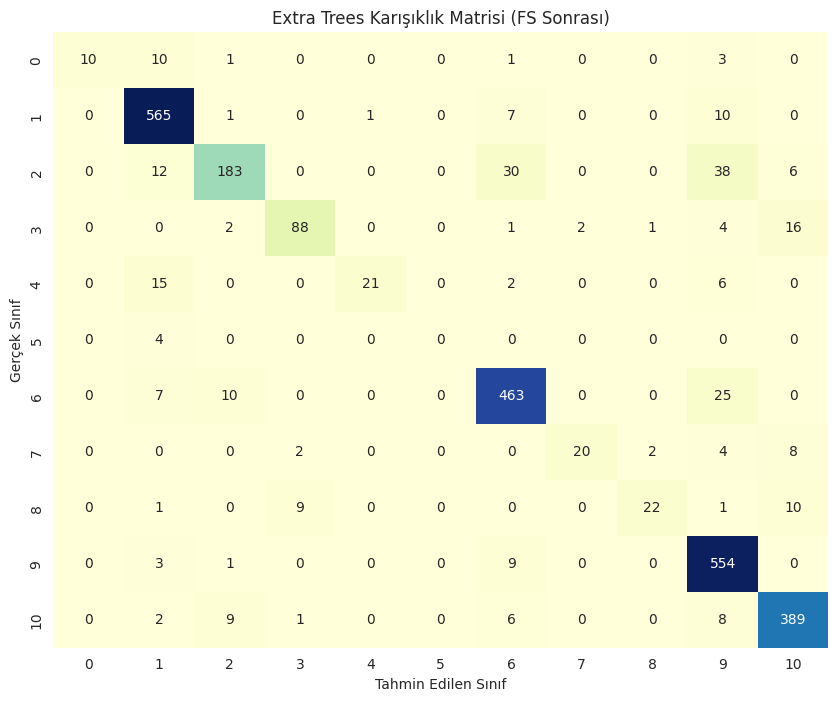

/tmp/ipython-input-3869184583.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', n_classes)


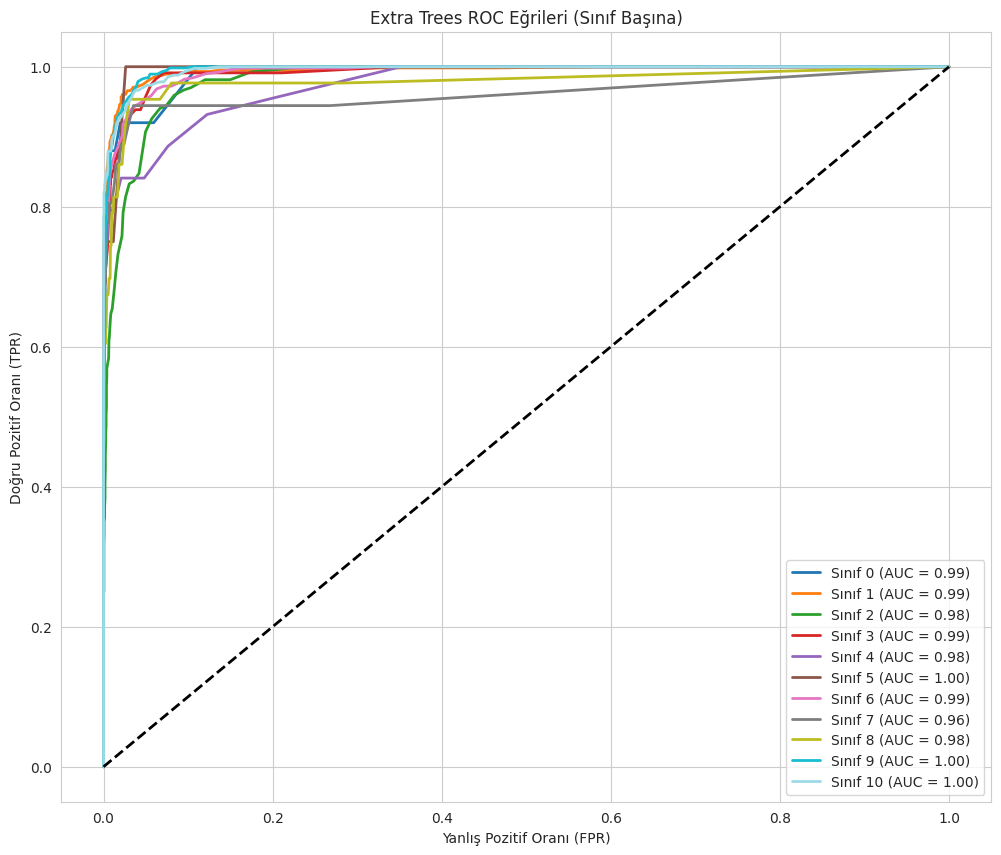

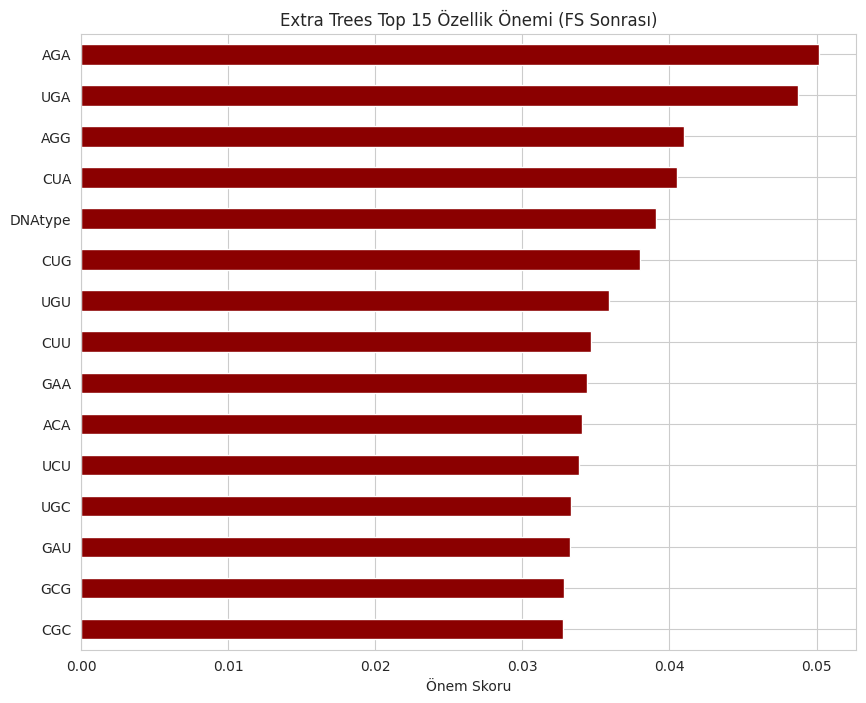

In [12]:

# Extra Trees için Veri Seçimi (Feature Selection)"
# ------------------------------------------------------------------------------
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

print("--- 2. Extra Trees ile Öznitelik Seçimi (FS - Gömülü Yöntem) ---")

# Extra Trees modelini bir selector olarak eğitme işlemi
et_selector = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_selector.fit(X_train_et, y_train_final)

# SelectFromModel'i kullanarak öznitelik önem skoru ortalamanın üzerinde olanları seçme işlemi
# (threshold="mean")
model_selector = SelectFromModel(et_selector, threshold="mean", prefit=True)

# Seçilen özellikleri hem train hem test setlerine uygula
X_train_et_selected = model_selector.transform(X_train_et)
X_test_et_selected = model_selector.transform(X_test_et)

selected_features_mask = model_selector.get_support()
selected_feature_names = X_train_et.columns[selected_features_mask]

print(f"FS Öncesi Özellik Sayısı: {X_train_et.shape[1]}")
print(f"FS Sonrası Seçilen Özellik Sayısı: {X_train_et_selected.shape[1]}")
print(f"Seçilen İlk 5 Özellik: {list(selected_feature_names[:5])}...")


# Farklı aşamalarda deneyerek aldığımız sonuçları karşılaştırma:

from sklearn.metrics import accuracy_score, classification_report

print("\n--- 3. Extra Trees Classifier - Base Model 1 Uygulama ---")

et_model = ExtraTreesClassifier(n_estimators=100, random_state=42)

# =================================================================
# 1- FS Yapılmamış Veri (FE Sonrası)
# =================================================================
print("\n--- 1- Sadece FE Yapılmış Veri ile Eğitim -Başlangıç ---")
et_model_fe_only = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_model_fe_only.fit(X_train_et, y_train_final)
y_pred_original_fe = et_model_fe_only.predict(X_test_et)
y_proba_original_fe = et_model_fe_only.predict_proba(X_test_et)


# Sınıflandırma raporu detayları
print("\n--- EXTRA TREES SINIFLANDIRMA RAPORU -FS Öncesi ---")
print(classification_report(y_test_final, y_pred_original_fe, zero_division=0))


# Metrikleri Hesaplama
report_original = classification_report(y_test_final, y_pred_original_fe, output_dict=True, zero_division=0)
print(f"Doğruluk (Accuracy): {report_original['accuracy']:.4f}")
print(f"Makro F1 Skoru: {report_original['macro avg']['f1-score']:.4f}")


# =================================================================
# 2- FS Yapılmış Veri (FE ile FS Sonrası)
# =================================================================
print("\n--- 2- FE ve FS Yapılmış Veri ile Eğitim (Karşılaştırma) ---")
et_model_fs_selected = ExtraTreesClassifier(n_estimators=100, random_state=42)
et_model_fs_selected.fit(X_train_et_selected, y_train_final)
y_pred_et_selected = et_model_fs_selected.predict(X_test_et_selected)
y_proba_et_selected = et_model_fs_selected.predict_proba(X_test_et_selected)

# Metrikleri Hesaplama
report_selected = classification_report(y_test_final, y_pred_et_selected, output_dict=True, zero_division=0)

print("\n--- EXTRA TREES SINIFLANDIRMA RAPORU (FS Sonrası) ---")
print(classification_report(y_test_final, y_pred_et_selected, zero_division=0))

print(f"Doğruluk (Accuracy): {report_selected['accuracy']:.4f}")
print(f"Makro F1 Skoru: {report_selected['macro avg']['f1-score']:.4f}")

# =================================================================

# 1. KARMAŞIKLIK MATRİSİ (Confusion Matrix)

cm = confusion_matrix(y_test_final, y_pred_et_selected)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.title('Extra Trees Karışıklık Matrisi (FS Sonrası)')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.show()

# 2. ROC EĞRİSİ - Çok Sınıflı

y_test_binarize = label_binarize(y_test_final, classes=np.unique(y_train_final))
n_classes = y_test_binarize.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    # Eğer sınıfta hiç örnek yoksa veya sadece tek bir değer varsa:
    if np.sum(y_test_binarize[:, i]) == 0:
        roc_auc[i] = np.nan
        continue
    fpr[i], tpr[i], _ = roc_curve(y_test_binarize[:, i], y_proba_et_selected[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(12, 10))
colors = plt.cm.get_cmap('tab20', n_classes)
for i in range(n_classes):
    if not np.isnan(roc_auc[i]):
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label=f'Sınıf {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title('Extra Trees ROC Eğrileri (Sınıf Başına)')
plt.xlabel('Yanlış Pozitif Oranı (FPR)')
plt.ylabel('Doğru Pozitif Oranı (TPR)')
plt.legend(loc="lower right")
plt.show()


# 3. Özellik Önemi(Feature Importance) Görseli

feature_importances = et_model_fs_selected.feature_importances_
selected_feature_names = X_train_et.columns[model_selector.get_support()]

# Seçilen özelliklerin önem skorlarını al
feature_series = pd.Series(feature_importances, index=selected_feature_names)
top_n = 15 # En önemli ilk 15 özelliği göster

plt.figure(figsize=(10, 8))
feature_series.nlargest(top_n).sort_values().plot(kind='barh', color='darkred')
plt.title(f'Extra Trees Top {top_n} Özellik Önemi (FS Sonrası)')
plt.xlabel('Önem Skoru')
plt.show()
